# Libraries

In [1]:
# Importing the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from scipy import stats

# FUNÇÕES DE AJUDA

# Identificar Var Numéricas e Categóricas

In [2]:
# 1. Get numerical and categorical features (df, target_col='Attack Type') -> numerical features; categorical features
def get_feature_types(df, target_col='Attack Type'):
    """
    Identify numeric and categorical features, if present, in the dataset.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    target_col : str, optional (default='Attack Type')
        Name of the target column to exclude from features

    Returns:
    --------
    tuple : (list, list)
        Two lists containing:
        - numeric_features: List of column names with numerical data
        - categorical_features: List of column names with categorical data

    Notes:
    ------
    - Numerical features are identified as columns containing numeric data types
    - Categorical features are identified as columns containing object data types
    - The target column is excluded from both feature lists if present
    """

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

# Analizar Correlação Entre Features Numéricas

In [3]:
# 2. Correlation analysis (df, numeric_features) -> list of tuples with highly correlaed features
def correlation_analysis(df, numeric_features, threshold=0.85):
    """
    Analyze correlations between numerical features.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    threshold : float
        Threshold for determining highly correlated features (default='0.85')

    Returns:
    --------
    list of tuples
        List of highly correlated feature pairs and their correlation values
        Each tuple contains (feature1, feature2, correlation_value)

    Notes:
    ------
    - Generates a correlation matrix heatmap
    - Identifies feature pairs with absolute correlation > 0.85
    - Only returns upper triangle of correlation matrix to avoid duplicates
    - The heatmap uses a diverging color scheme centered at 0
    """

    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

# Análise de Homogeneidade da Variância (Teste de Levene's)

In [4]:
# 3. Variance analysis (df, numeric_features, target_col='Attack Type') – Levene -> dict with results
def analyze_variance_homogeneity(df, numeric_features, target_col='Attack Type'):  
    """  
    Analyze the homogeneity of variances using Levene's test.  

    Parameters:  
    -----------  
    df : pandas.DataFrame  
        Input DataFrame containing the dataset.  
    numeric_features : list  
        List of column names containing numerical features to analyze. 
    target_col : str, optional (default='Attack Type')
        Name of the target column

    Returns:  
    --------  
    dict  
        Dictionary containing the results of Levene's test for each feature.  
    """  
    
    results_levene = {}  
    
    for feature in numeric_features:  
        # Group data by y and filter out groups with zero values  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)   
                  if not group[feature].dropna().empty]  
        
        # Filter out groups that contain only zero values or have zero variance  
        groups = [group for group in groups if len(group) > 0 and np.any(group != 0) and np.var(group) > 0]  
        
        # Check if there are at least two groups with valid data  
        if len(groups) < 2:  
            print(f"Not enough valid groups to perform Levene's test for feature: {feature}")  
            continue  # Skip this feature if not enough valid groups  

        # Perform Levene's Test  
        stat_levene, p_value_levene = stats.levene(*groups)  
        results_levene[feature] = {'Statistic': stat_levene, 'p-value': p_value_levene}  

    return results_levene

# Análise da Importância das Features com Teste Kurskal-Wallis

In [5]:
# 4. Feature importance analysis (df, numeric_features, target_col='Attack Type') – Kruskal-Wallis -> df with H-statistics and p-values
def analyze_feature_importance(df, numeric_features, target_col='Attack Type'):
    """  
    Analyze feature importance using the Kruskal-Wallis test.  

    Parameters:  
    -----------  
    df : pandas.DataFrame  
        Input DataFrame containing the dataset  
    numeric_features : list  
        List of column names containing numerical features to analyze  
    target_col : str, optional (default='Attack Type')
        Name of the target column

    Returns:  
    --------  
    pandas.DataFrame  
        DataFrame containing H-statistics and p-values for each feature,  
        sorted by H-statistic in descending order  

    Notes:  
    ------  
    - Uses the Kruskal-Wallis test to assess feature importance  
    - Higher H-statistic indicates stronger relationship with target variable  
    - Generates bar plot of H-statistics for visual comparison  
    - Features are sorted by importance in the visualization  
    """  

    h_scores = {}  
    
    for feature in numeric_features:  
        # Group data by y and perform the Kruskal-Wallis test  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)]  
        h_stat, p_val = stats.kruskal(*groups)  
        h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}  

    # Create a DataFrame from the results  
    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')  
    h_scores_df = h_scores_df.sort_values('H-statistic', ascending=False)  

    # Plotting H-statistics  
    plt.figure(figsize=(18, 10))  
    plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')  
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)  
    plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')  
    plt.xlabel('Features')  
    plt.ylabel('H-statistic')  
    plt.tight_layout()  
    plt.show()  

    return h_scores_df

# Análise da Importância das Features com Random Forest

In [6]:
# 5. Feature importance analysis(df, numeric_features, target_col='Attack Type') – Tree Model -> df with features ordered by importance; confusion matrix; labels; cv_scores
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):
    """
    Analyze feature importance using a Random Forest classifier.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    target_col : str
        Column name of the target variable

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing feature importances sorted by importance in descending order
    cm
        Confusion Matrix for further analysis
    rf_labels
        Labels for plotting the confusion matrix
    cv_scores
        Cross-validation scores for future reference

    Notes:
    ------
    - Uses a Random Forest classifier to assess feature importance.
    - Generates bar plot of feature importances for visual comparison.
    """

    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 150,    # Number of trees
        'max_depth': 30,        # Limit tree depth
        'random_state': 42,     # For reproducibility
        'n_jobs': -1            # Use all available cores
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Create the Random Forest model with specified hyperparameters
    rf = RandomForestClassifier(**hyperparameters)

    # Fit the model on the training set
    rf.fit(X_train, y_train)

    # Cross-validation on the training set
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
    
    # Predict on test set
    y_pred = rf.predict(X_test)

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix
    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    # Calculate test scores
    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    # Plot feature importances
    plt.figure(figsize=(18, 12))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Feature Importance from Random Forest')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores

# Cálculo da Percentagem de Outliers para Cada Feature com IQR

In [7]:
# 6. Calculation of the percentage of outliers for each feature (df) – IQR -> dict with outliers percentage
def calculate_outliers_percentage(df):
    """
    Calculate the percentage of outliers for each feature in the DataFrame using the IQR method.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset.

    Returns:
    --------
    dict
        Dictionary containing the percentage of outliers for each feature.

    Notes:
    ------
    - Uses the Interquartile Range (IQR) method to identify outliers.
    - Outliers are defined as values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
    - The function returns a dictionary with feature names as keys and outlier percentages as values.
    """

    outlier_percentages = {}  # empty dictionary to store outlier percentages

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # first quartile (Q1) for the column
        Q3 = df[column].quantile(0.75)  # third quartile (Q3) for the column
        IQR = Q3 - Q1  # Interquartile Range (IQR)

        lower_bound = Q1 - 1.5 * IQR  # lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # upper bound for outliers

        # Identify outliers in the column
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the percentage of outliers for the column
        outlier_percentage = len(outliers) / len(df) * 100

        # Store the outlier percentage in the dictionary
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

# 1. EXPLORAÇÃO INICIAL

# 1.1. Carregar o Ds

In [8]:
# List to store DataFrames
dfs = []

# Load the datasets
for dirname, _, filenames in os.walk('ds'):
    for filename in filenames:
        dfs.append(pd.read_csv(os.path.join(dirname, filename)))

In [9]:
# Data dimensions of each individual dataset
for i, data in enumerate(dfs, start=1):
    rows, cols = data.shape
    print(f'df{i} -> {rows} rows, {cols} columns')

df1 -> 288602 rows, 79 columns
df2 -> 529918 rows, 79 columns
df3 -> 191033 rows, 79 columns
df4 -> 286467 rows, 79 columns
df5 -> 225745 rows, 79 columns
df6 -> 445909 rows, 79 columns
df7 -> 692703 rows, 79 columns
df8 -> 170366 rows, 79 columns


# 1.2. Junção dos Dataframes

In [10]:
# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dfs, axis=0, ignore_index=True)

# Deleting DataFrames after merging
for df in dfs: del df

# 1.3. Overview dos Dados

In [11]:
# Display the first few rows
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN


In [12]:
# Apresentação de 10 linhas aleatórias
data.sample(n=10, random_state=42)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,53,30767,2,2,70,102,35,35,35.000000,0.000000,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
946912,53,48461,2,2,76,200,38,38,38.000000,0.000000,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
2216843,80,1,2,0,0,0,0,0,0.000000,0.000000,...,32,0.0000,0.00000,0,0,0.000,0.0000,0,0,DoS Hulk
699389,53,191,2,2,74,138,37,37,37.000000,0.000000,...,32,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
1170268,2126,33,1,1,0,6,0,0,0.000000,0.000000,...,40,0.0000,0.00000,0,0,0.000,0.0000,0,0,PortScan
800686,44761,52,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
1434488,31843,4000835,1,4,1375,18,1375,1375,1375.000000,0.000000,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
1968368,443,60397661,13,12,984,3402,596,0,75.692308,168.374278,...,20,119347.1667,85254.73309,293371,84195,9946905.833,109697.6633,9993438,9723071,BENIGN
934343,443,263886,6,10,1091,4995,549,0,181.833333,226.009218,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
693547,52676,36,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN


In [13]:
# Get dataset dimensions
print(f"Dataset Dimensions: {data.shape}")

Dataset Dimensions: (2830743, 79)


In [14]:
# Display data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [15]:
# Checking for missing values
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Printing columns with missing values
for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

Column 'Flow Bytes/s' has 1358 missing values, which is 0.05% of the total


# 2. Limpeza de Dados

In [16]:
# Removal of leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

# 2.1. Dados Duplicados

In [17]:
# Checking and counting duplicates
duplicates = data.duplicated()
duplicate_count = duplicates.sum()

# Output results
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 308381


In [18]:
# Removal of duplicates
data = data.drop_duplicates(keep='first')
del duplicates
data.shape

(2522362, 79)

In [19]:
# Identify columns with identical data
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Print the result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


In [20]:
# Removing the columns with duplicated values
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

In [21]:
print(data.columns)
data.shape

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

(2522362, 67)

In [22]:
# Checking for infinite values
num_columns = data.select_dtypes(include = np.number).columns
has_infinite = np.isinf(data[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [23]:
# Treating infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2.1. Valores em Falta

In [24]:
# Attack counts
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = data.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Bot,1953,1948,5,0.26


In [25]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [26]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total rows with missing values: 1564


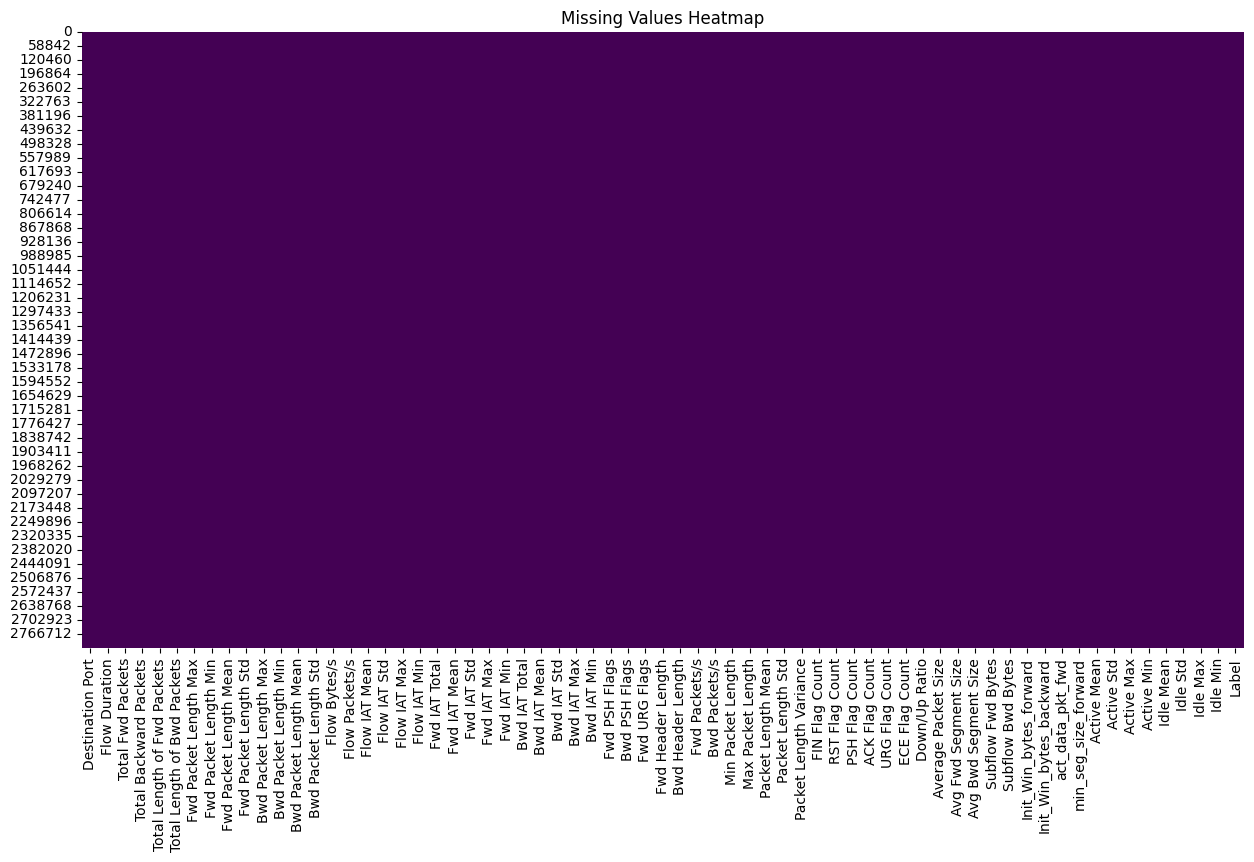

In [27]:
#Heatmap com missing values
plt.figure(figsize=(15, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [28]:
# Dropping missing values
data = data.dropna()
print(f'Dataset shape after row-wise removal: {data.shape}')

Dataset shape after row-wise removal: (2520798, 67)


# Descriptive Statistics

In [29]:
print("\nDescriptive Statistics:")
print(data.describe(include='all'))


Descriptive Statistics:
        Destination Port  Flow Duration  Total Fwd Packets  \
count       2.520798e+06   2.520798e+06       2.520798e+06   
unique               NaN            NaN                NaN   
top                  NaN            NaN                NaN   
freq                 NaN            NaN                NaN   
mean        8.690590e+03   1.659161e+07       1.028174e+01   
std         1.901280e+04   3.523276e+07       7.944201e+02   
min         0.000000e+00  -1.300000e+01       1.000000e+00   
25%         5.300000e+01   2.080000e+02       2.000000e+00   
50%         8.000000e+01   5.062200e+04       2.000000e+00   
75%         4.430000e+02   5.333340e+06       6.000000e+00   
max         6.553500e+04   1.200000e+08       2.197590e+05   

        Total Backward Packets  Total Length of Fwd Packets  \
count             2.520798e+06                 2.520798e+06   
unique                     NaN                          NaN   
top                        NaN           

# 2.2. Data-Driven Feature Selection

In [30]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


In [31]:
# Dropping the columns with only one unique value
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [32]:
data.shape

(2520798, 66)

# 2.3. Agrupar/Remover Tipos de Ataque

No Ds são categorizados vários tipos de ataque (como é o exemplo das diferentes distinções de DoS).
Dada a falta de equilíbrio no Ds, consolidar estes dados pode ajudar no treino dos Modelos.

# 2.3.1. Agrupar Ataques

In [33]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Map to new group column
data['Attack Type'] = data['Label'].map(group_mapping)

In [34]:
# Checking the new values
data['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64

In [35]:
# Dropping the old 'Label' column
data.drop(columns='Label', inplace=True)

# 2.3.2. Remoção de Tipos de Ataques

Vão ser removidos os ataques 'Inflitração' e 'Variados' pois, no futuro, podem ter consequências na fiabilidade do modelo.

In [36]:
# Removing rows with statistically irrelevant attack types
data.drop(data[(data['Attack Type'] == 'Infiltration') | (data['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [37]:
# Data shape and attack counts after removal
print(data.shape)
data['Attack Type'].value_counts()

(2520751, 66)


Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

# 3. EDA

# 3.1. Estatísticas

In [38]:
data.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
1690981,80,119017525,21,17,1302,5887,434,0,62.00,155.618765,...,32,3.592447e+05,1112185.469,3712608,22977,10200000.0,69932.06462,10200000,10000000,Normal Traffic
1399287,26433,3816066,1,5,6,30,6,6,6.00,0.000000,...,20,0.000000e+00,0.000,0,0,0.0,0.00000,0,0,Normal Traffic
2743744,53487,19,2,0,37,0,31,6,18.50,17.677670,...,20,0.000000e+00,0.000,0,0,0.0,0.00000,0,0,Normal Traffic
821601,53,97077,2,2,68,132,34,34,34.00,0.000000,...,32,0.000000e+00,0.000,0,0,0.0,0.00000,0,0,Normal Traffic
1800344,61775,29,1,1,0,0,0,0,0.00,0.000000,...,20,0.000000e+00,0.000,0,0,0.0,0.00000,0,0,Normal Traffic
2148226,80,99240068,8,6,686,11595,340,0,85.75,156.940161,...,20,2.006000e+03,0.000,2006,2006,98900000.0,0.00000,98900000,98900000,DoS
930246,53,48071,1,1,45,122,45,45,45.00,0.000000,...,32,0.000000e+00,0.000,0,0,0.0,0.00000,0,0,Normal Traffic
1770218,9148,1359904,2,0,62,0,31,31,31.00,0.000000,...,20,0.000000e+00,0.000,0,0,0.0,0.00000,0,0,Normal Traffic
1411251,80,86327492,8,5,56,11607,20,0,7.00,5.656854,...,20,3.905920e+06,0.000,3905920,3905920,81200000.0,0.00000,81200000,81200000,DDoS
931444,53,149,2,2,98,130,49,49,49.00,0.000000,...,32,0.000000e+00,0.000,0,0,0.0,0.00000,0,0,Normal Traffic


In [39]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,...,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06
mean,8.690744e+03,1.659032e+07,1.025880e+01,1.155289e+01,6.065243e+02,1.811292e+04,2.311993e+02,1.920377e+01,6.350189e+01,7.732029e+01,...,5.997266e+00,-3.082291e+03,9.152230e+04,4.616835e+04,1.719410e+05,6.542438e+04,9.337159e+06,5.656738e+05,9.763454e+06,8.892545e+06
std,1.901294e+04,3.523140e+07,7.943824e+02,1.056905e+03,1.011595e+04,2.398149e+06,7.563122e+02,6.079887e+01,1.955512e+02,2.968824e+02,...,6.743909e+02,1.149769e+06,6.858746e+05,4.161453e+05,1.084664e+06,6.106447e+05,2.484810e+07,4.873871e+06,2.561725e+07,2.458139e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.062000e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.625000e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.332968e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.970000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.419280e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


# 3.2. Análise de Correlação

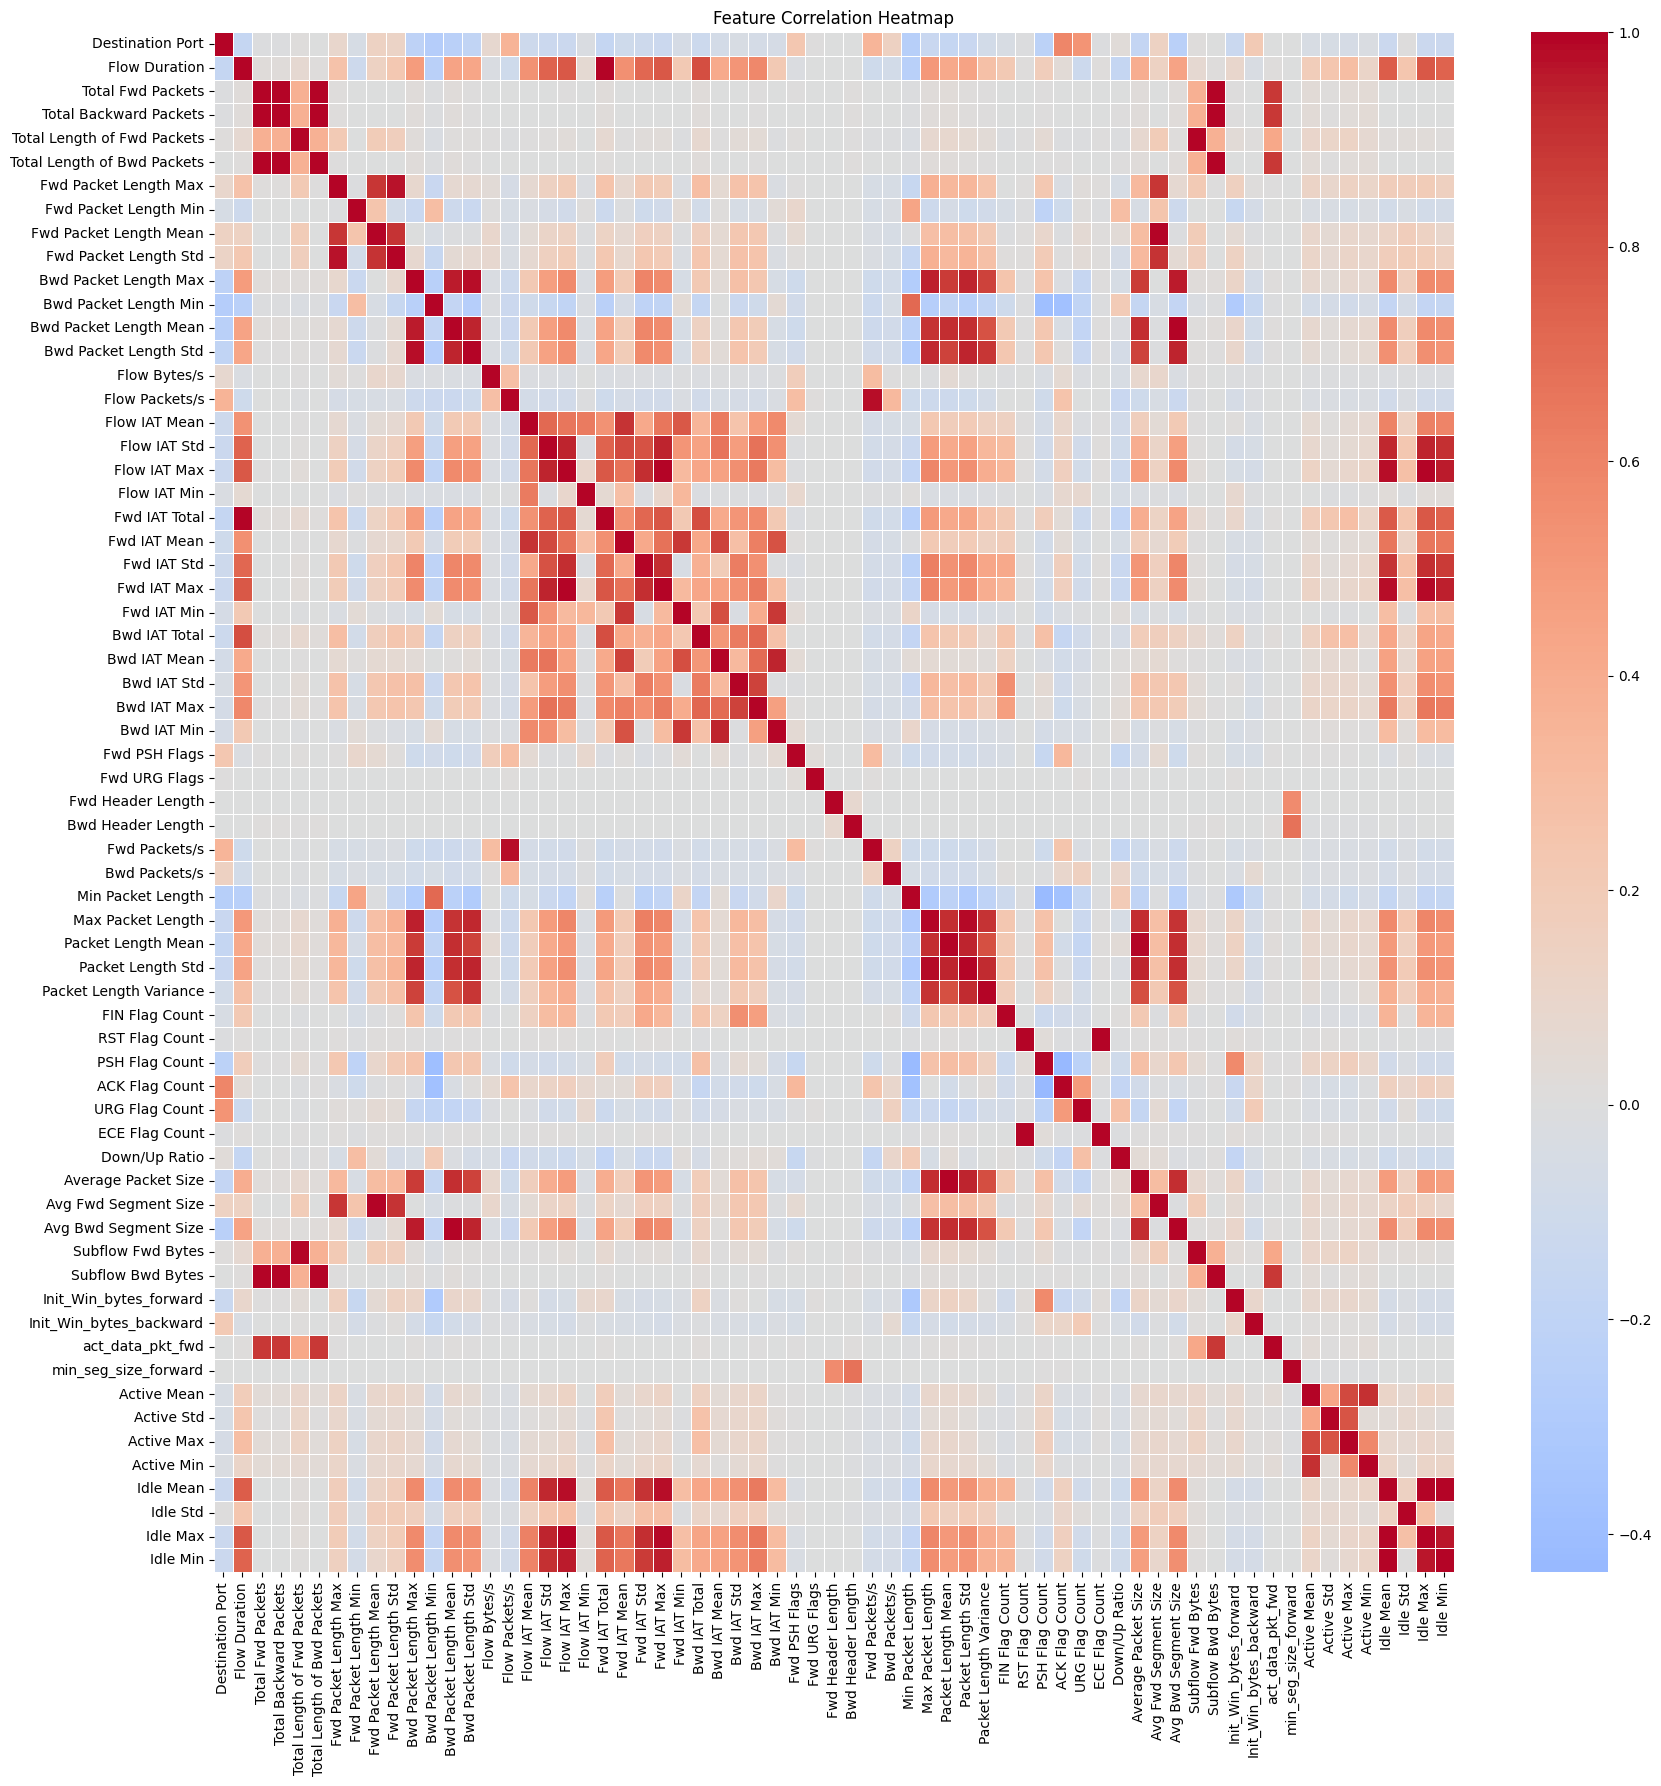

In [40]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(data)
high_corr = correlation_analysis(data, numeric_features)

In [41]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9985
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9945
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Fwd Packet Length Max has a high correlation with Fwd Packet Length Std: 0.968

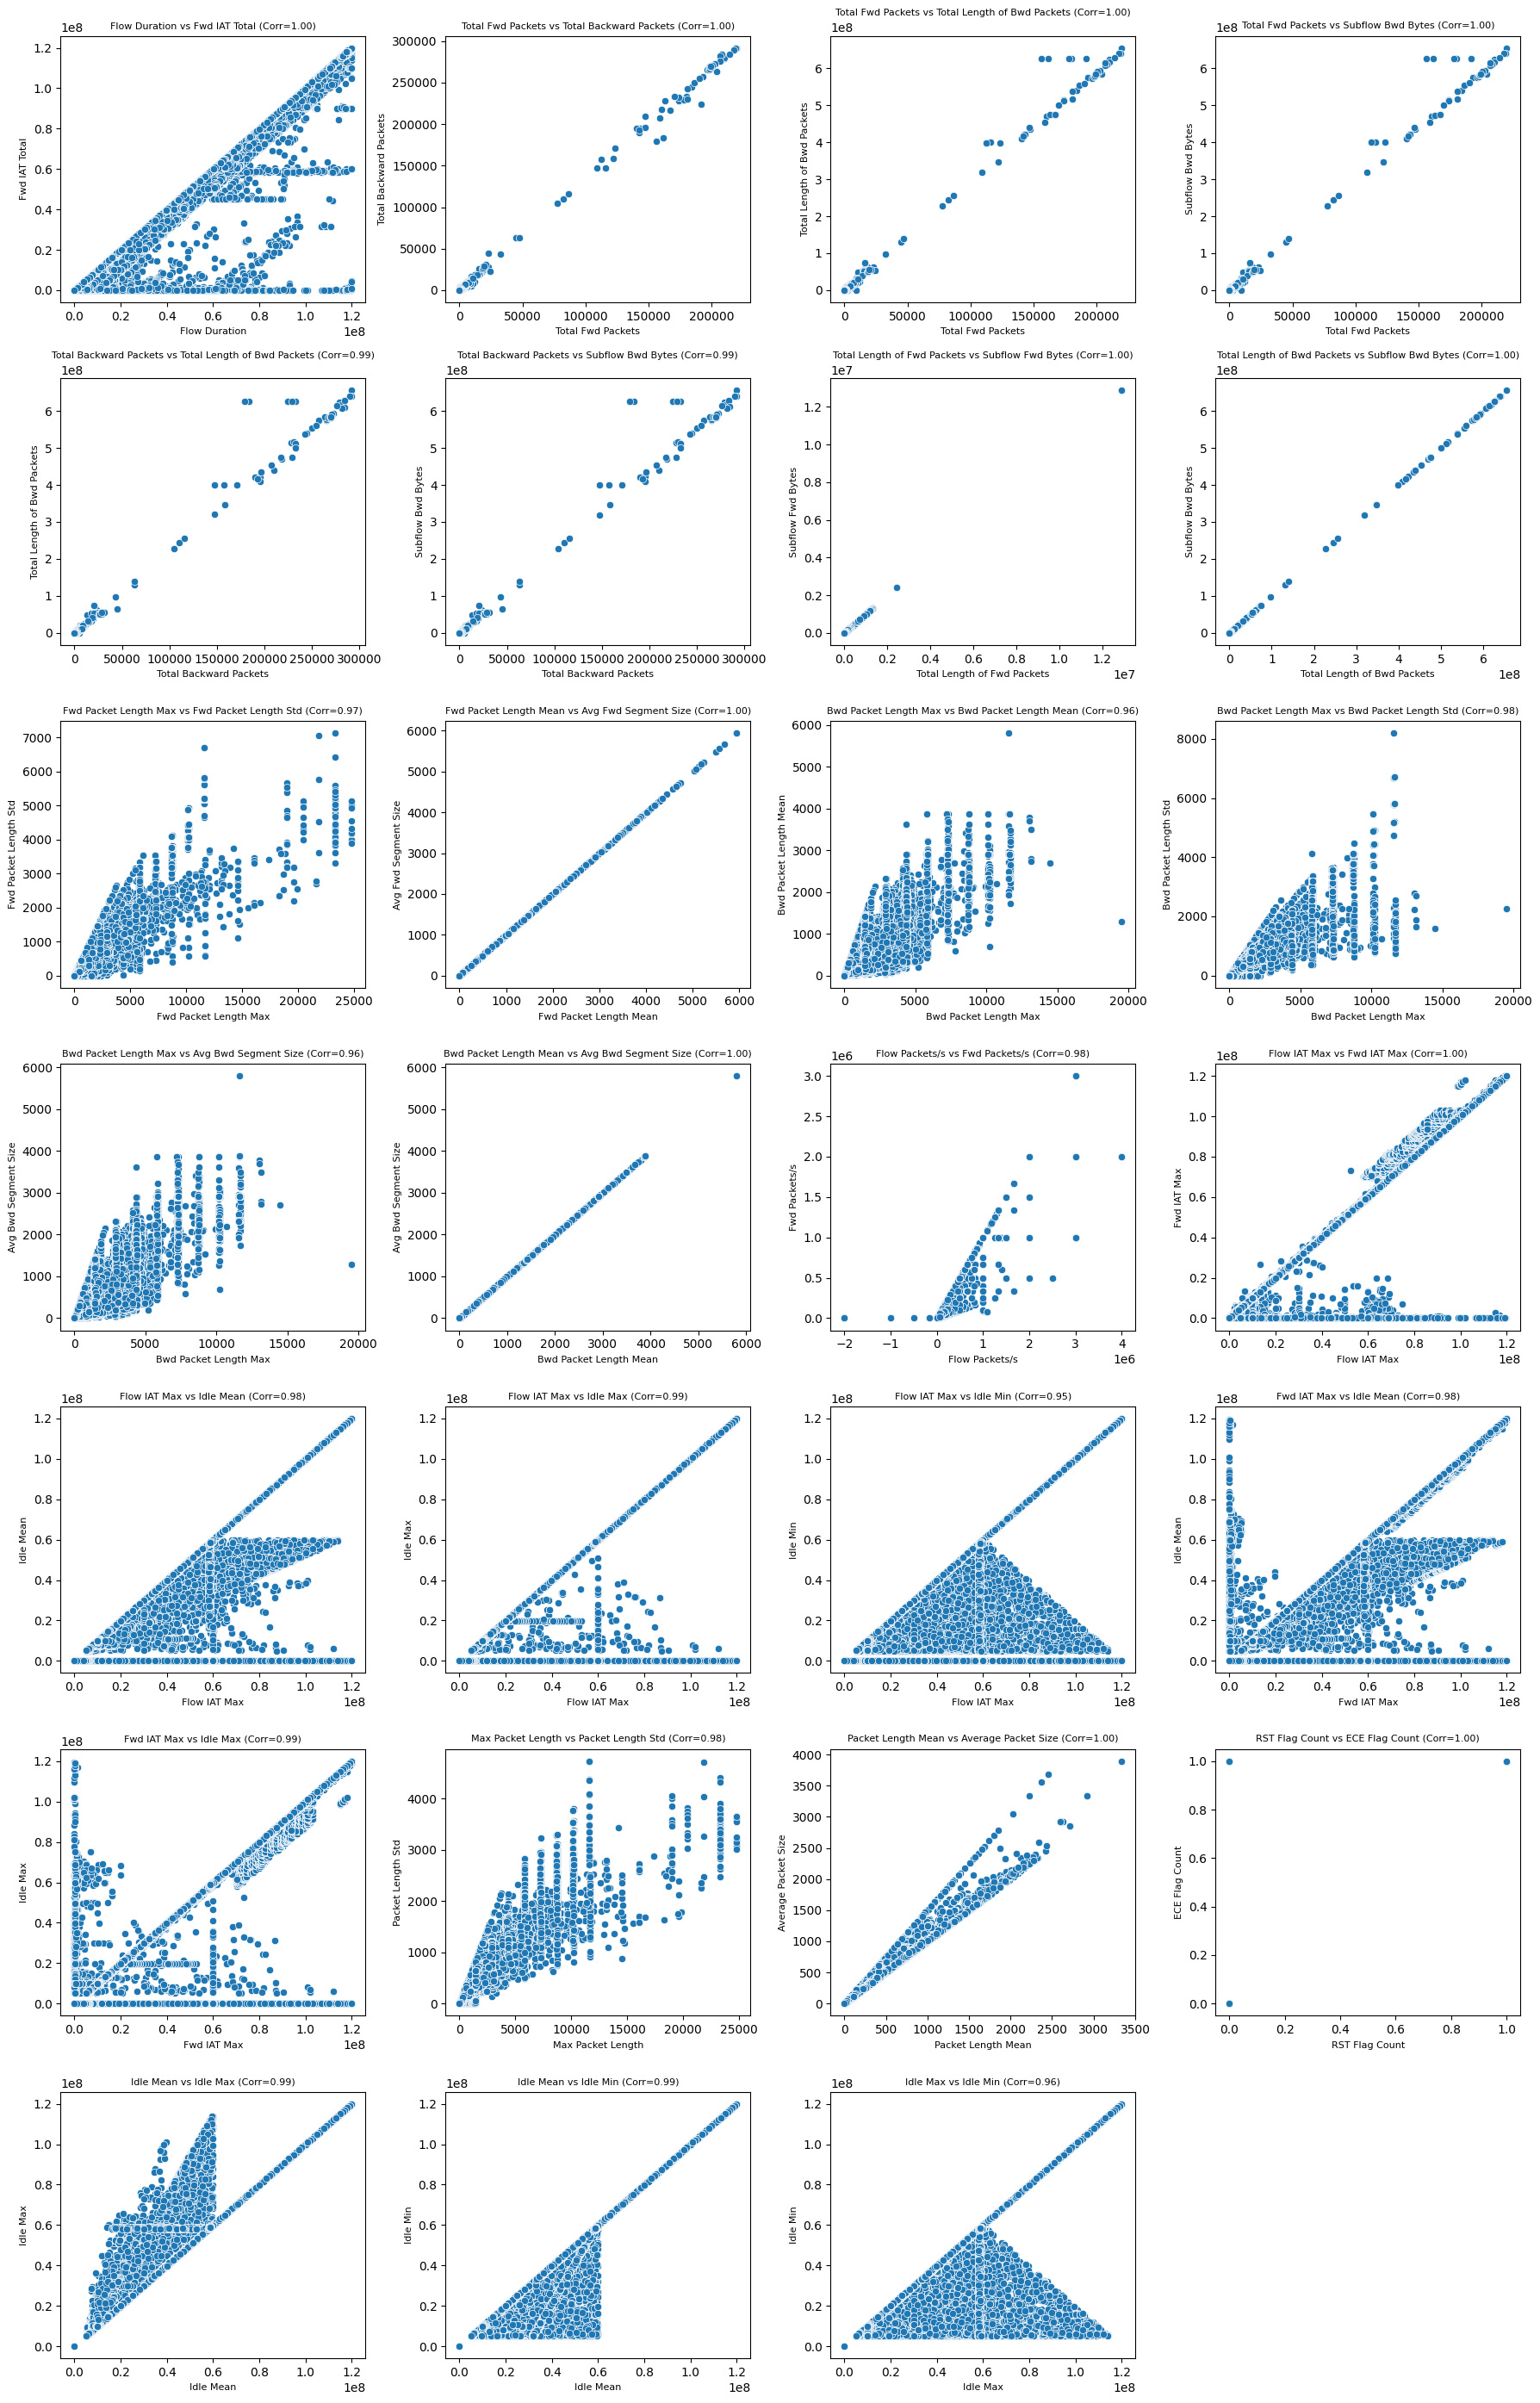

In [42]:
# Plotting the pairs with very high correlation for better visualization

n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [43]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
data.drop(columns=selected_columns, inplace=True)

In [44]:
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(data)
data.shape

(2520751, 61)

# 3.3. Outliers

<Figure size 1500x1000 with 0 Axes>

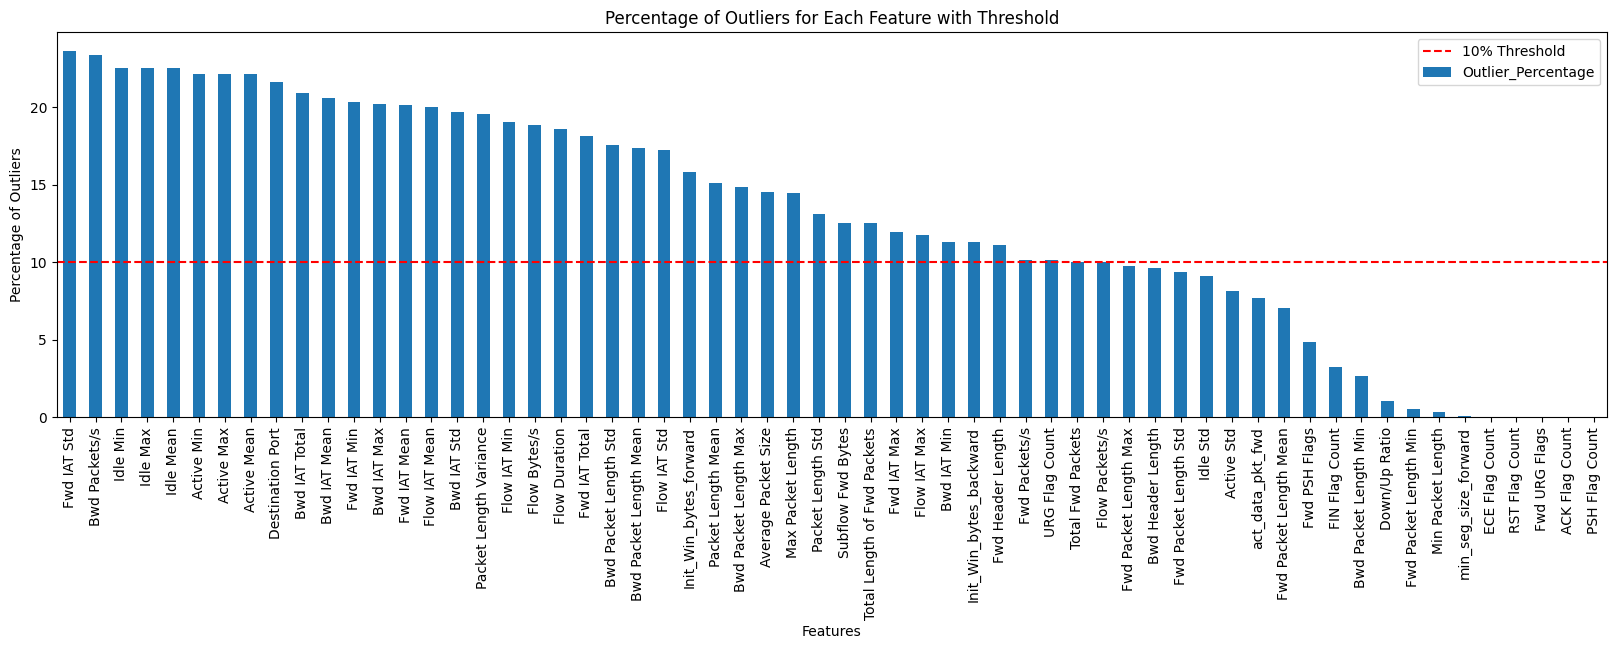

In [45]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(data[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

In [46]:
# Print the features with high outlier percentages
print(f"Features with outlier percentage above {threshold}%:\n")
print(high_outlier_features.sort_values('Outlier_Percentage', ascending=False))

# Cleaning up
del outliers_df

Features with outlier percentage above 10%:

                             Outlier_Percentage
Fwd IAT Std                           23.657989
Bwd Packets/s                         23.402391
Idle Min                              22.501508
Idle Max                              22.501508
Idle Mean                             22.501508
Active Min                            22.167917
Active Max                            22.167917
Active Mean                           22.167917
Destination Port                      21.645137
Bwd IAT Total                         20.926819
Bwd IAT Mean                          20.602908
Fwd IAT Min                           20.366311
Bwd IAT Max                           20.187555
Fwd IAT Mean                          20.126462
Flow IAT Mean                         19.985512
Bwd IAT Std                           19.700319
Packet Length Variance                19.538899
Flow IAT Min                          19.072649
Flow Bytes/s                          18.84

# 3.4. Distribuição dos Dados

Entnder a Distribuição Ajuda na Seleção do Modelo

In [47]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Perform Anderson-Darling test for normality
    result = stats.anderson(data[col], dist='norm')

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features are normally distributed')
print(f'{not_norm_dist} features are not normally distributed - Reject null hypothesis')

0 features are normally distributed
60 features are not normally distributed - Reject null hypothesis


# 3.5. Não Balanceamento das Classes

In [48]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = data['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2095057       83.11
1             DoS                 193745        7.69
2            DDoS                 128014        5.08
3   Port Scanning                  90694        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2143        0.09
6            Bots                   1948        0.08


A análise anterior apresenta uma clara falta de equilíbrio:
- Dominânica da classe 'BENIGN' - 83,1%
- Mesmo DoS sendo a 2ª classe mais relevante, tem muito poucas contagens
- Mesmo após o agrupamento, classes como 'Bots', 'Web Attacks' e 'Brute Force' são muito poucas

Implicações Possíveis
- Pode levar a um modelo 'biased' - com elevada Accuracy mas pouco recall e precisão, para classes mais pequenas
- Métricas de Perfromance - Devem ser bem escolhidas

Ideias para Problemas no Treino do Modelo
- Classes de Peso para penalizar erros nas classes minoritárias
- Métodos como Random Forest podem melhorar as Previsões
- Cross-Validation com folds representativas
- Diminuir as samples da classe maioritaria

In [49]:
del attack_counts_df

# 5. Importância das Features

Próximo passo será para determinar o melhor teste estatístico 

In [50]:
# Levene's Test
# p-value < 0.05 
variance_result = analyze_variance_homogeneity(data, numeric_features)

Not enough valid groups to perform Levene's test for feature: Fwd URG Flags
Not enough valid groups to perform Levene's test for feature: RST Flag Count
Not enough valid groups to perform Levene's test for feature: ECE Flag Count


In [51]:
# Analysing the results
no_significant_results = True

for feature, result in variance_result.items():   
    if result['p-value'] > 0.05:  
        print(f"\nFeature: {feature}")  
        print(f"  - Test Statistic: {result['Statistic']:.4f}")  
        print(f"  - p-value: {result['p-value']:.4f}")  
        print("  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).")  
        no_significant_results = False

# If no features had p-values > 0.05  
if no_significant_results:  
    print("\nNo features have p-values greater than 0.05. All features have significant differences in variance.")


Feature: Fwd Header Length
  - Test Statistic: 0.1504
  - p-value: 0.9890
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: Bwd Header Length
  - Test Statistic: 0.3305
  - p-value: 0.9213
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: min_seg_size_forward
  - Test Statistic: 0.6496
  - p-value: 0.6271
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).


# Análise da Importância de Features utilizando Kruskal-Wallis

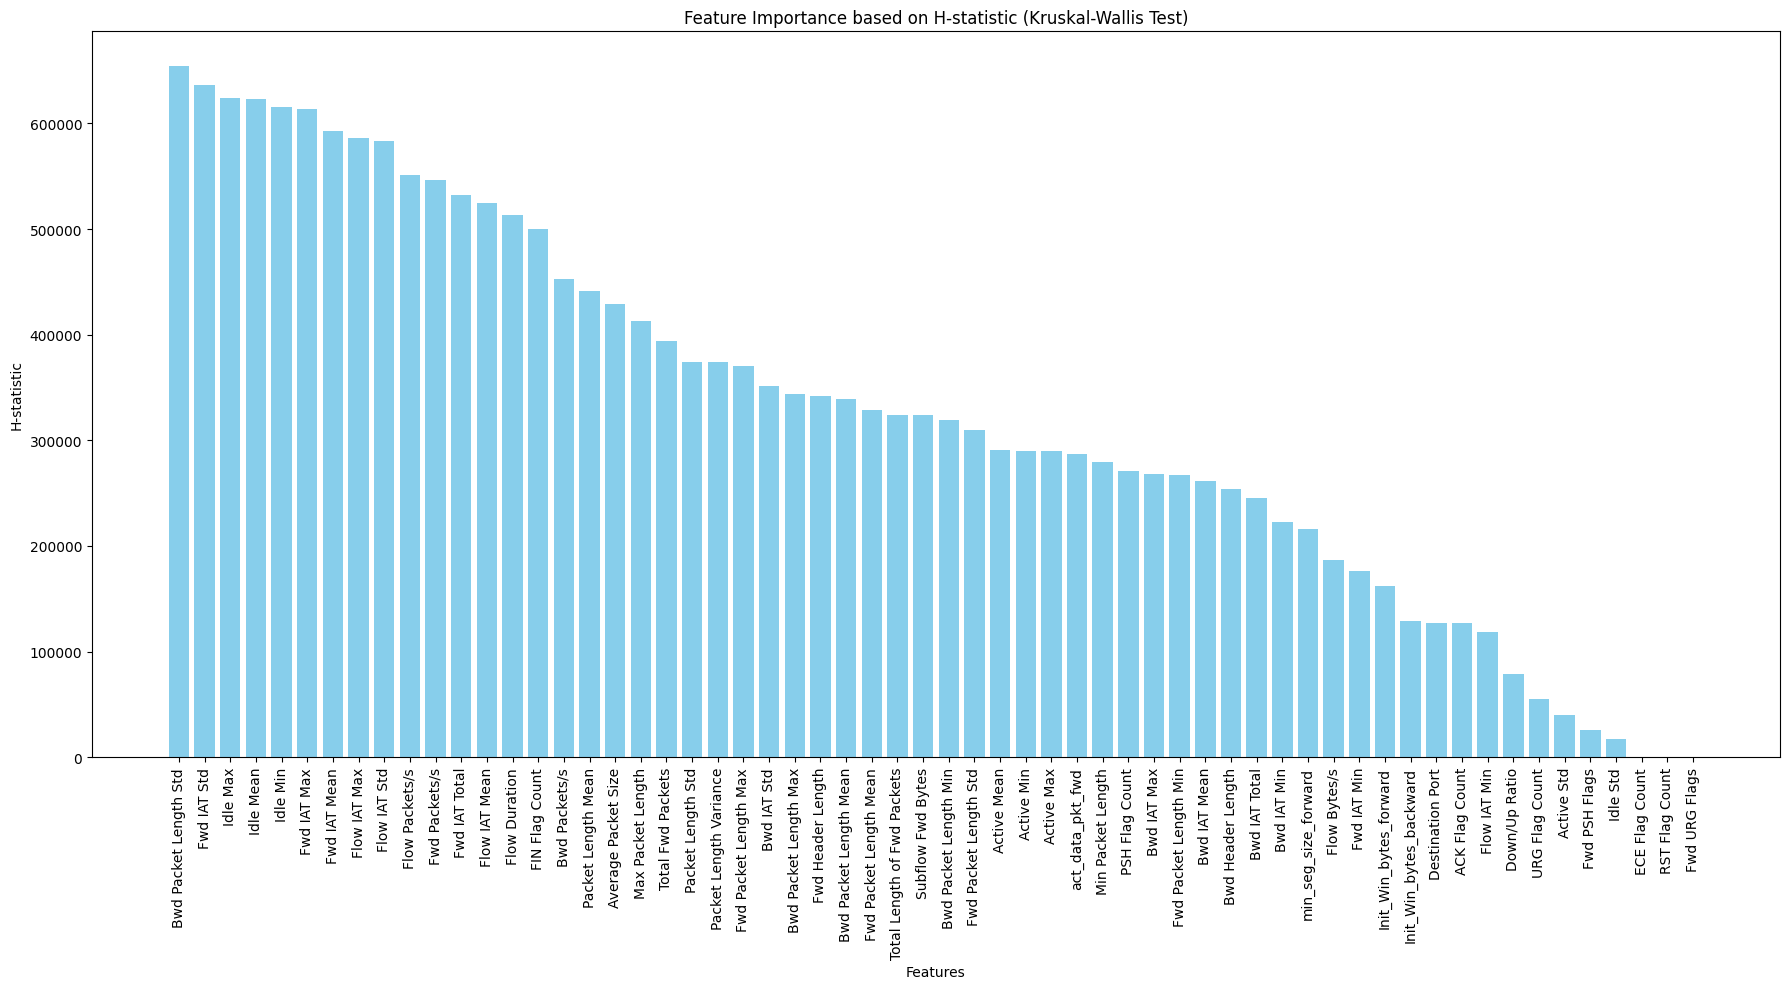

In [52]:
h_p_stats = analyze_feature_importance(data, numeric_features)

# Treinar um Modelo Random Forest e Analisar as Features Importance Scores

Cross-Validation Score: 0.9986 ± 0.0001

Classification Report:

                precision    recall  f1-score   support

          Bots       0.87      0.75      0.80       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      0.99      0.99     27208
   Web Attacks       0.99      0.97      0.98       643

      accuracy                           1.00    756226
     macro avg       0.98      0.96      0.97    756226
  weighted avg       1.00      1.00      1.00    756226




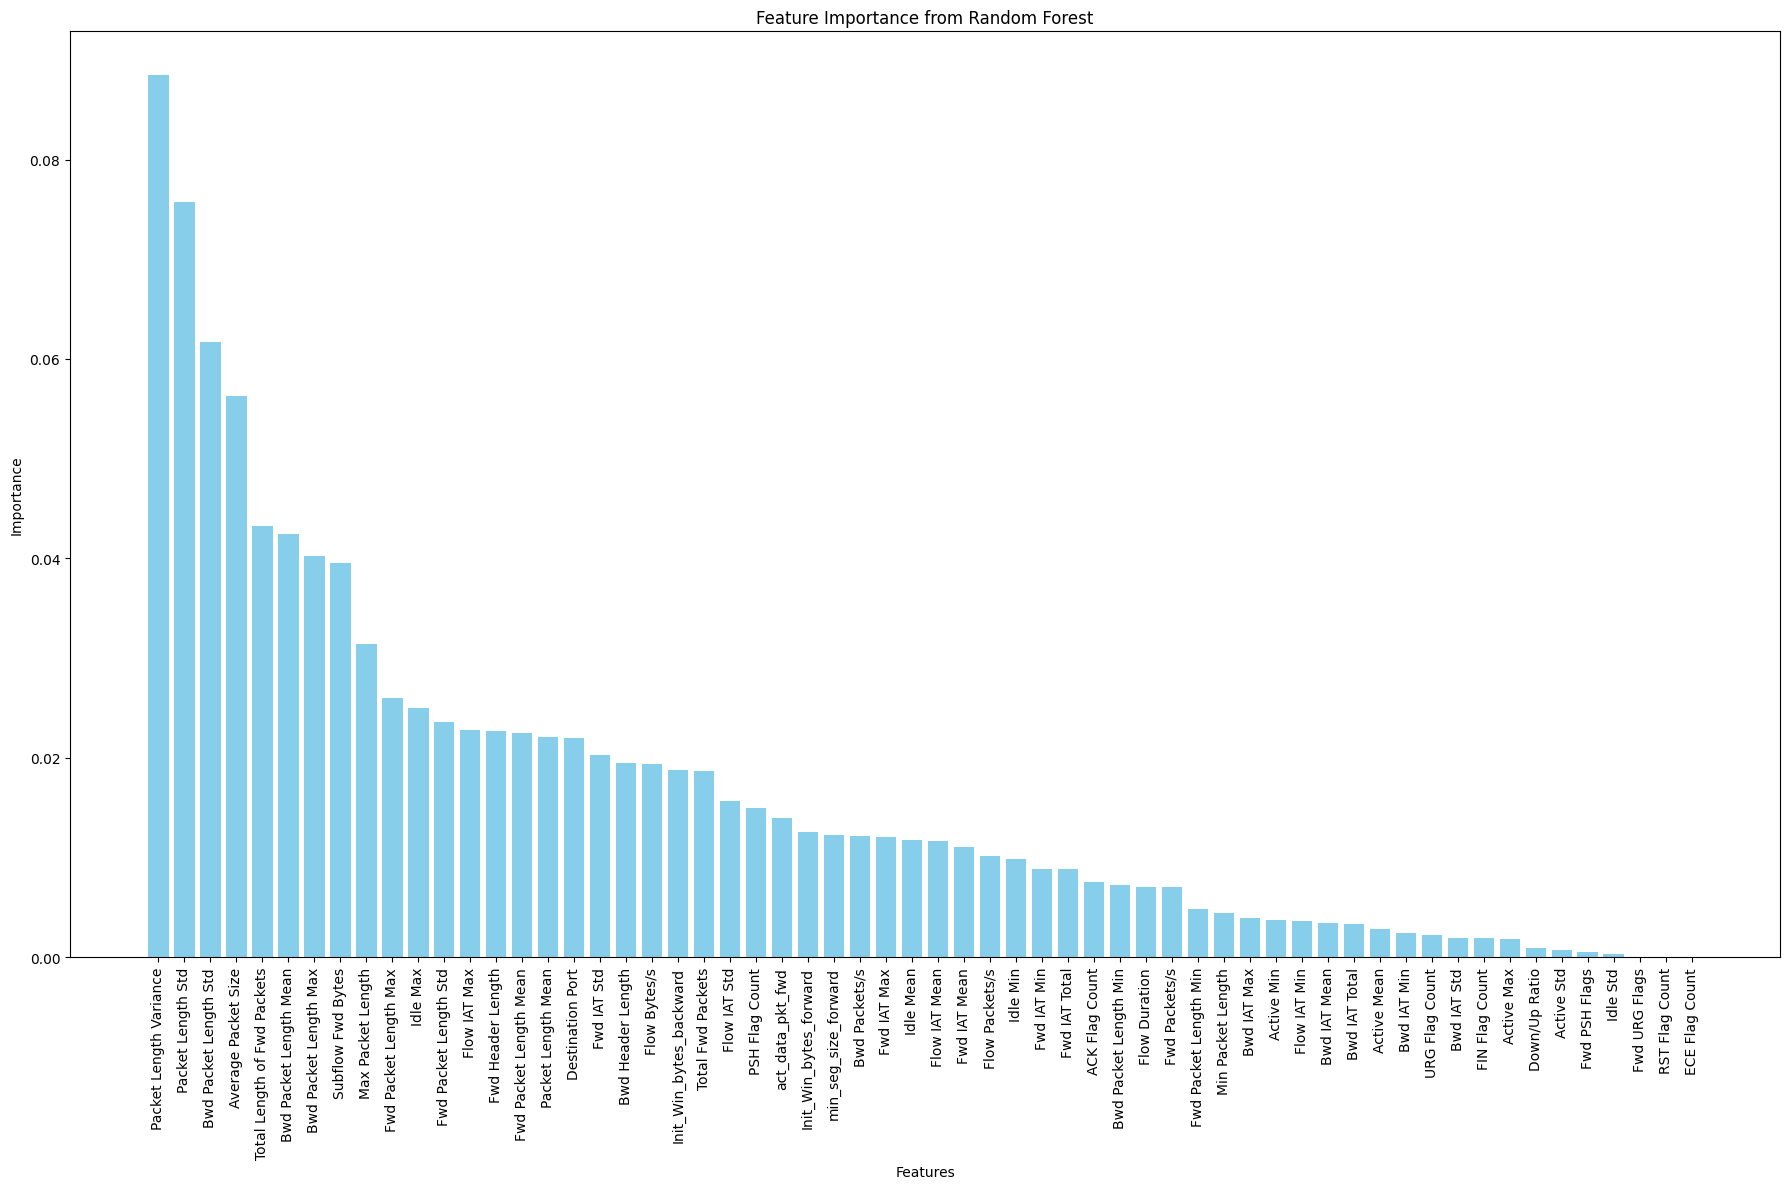

In [53]:
# Analysing feature importance using Tree-Model
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(data, numeric_features)